In [1]:
import os
import sys
import ast
import json

import clip
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTokenizer, CLIPModel, CLIPProcessor
from torchvision.transforms.functional import to_pil_image

import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class ArtDataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing subfolders like Cubism, Fauvism, etc.
            json_path (str): Path to the JSON file containing image labels/descriptions.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Load the JSON file
        with open(json_path, "r") as f:
            self.image_descriptions = json.load(f)

        # Create a list of (image_path, description) pairs
        self.samples = []
        for rel_path, description in self.image_descriptions.items():
            full_path = os.path.join(self.root_dir, rel_path)
            if os.path.exists(full_path):  # Ensure the file exists
                self.samples.append((full_path, description))
            else:
                print(f"Warning: File not found - {full_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load image
        img_path, description = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        # Apply transformation for normalized image
        if self.transform:
            normalized_image = self.transform(image)
        
        # Return normalized image and description for DataLoader
        return normalized_image, description

In [4]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [5]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

D:\Python\pytorch\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# Helper functions for encoding
# def encode_image(image):
#     inputs = processor(images=image, return_tensors="pt").to(device)
#     with torch.no_grad():
#         image_features = clip_model.get_image_features(**inputs)
#     return image_features.cpu().numpy()

def encode_image(image):
    # Denormalize the image
    image = denormalize(image)

    # Remove batch dimension and move to CPU
    image = image.squeeze(0).cpu()  # Shape: [C, H, W]

    # Convert to PIL image
    image = to_pil_image(image)

    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

def encode_text(text):
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    return text_features.cpu().numpy()[:, :512]  # Ensure 512 dimensions

# Denormalization function
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

# Compute similarity matrix
def compute_similarity_matrix(dataset):
    image_embeddings = []
    text_embeddings = []

    for i in range(len(dataset)): # len(dataset)
        _, raw_image, text = dataset[i]  # Use raw_image for CLIP
        image_embeddings.append(encode_image(raw_image))
        text_embeddings.append(encode_text(text))

    image_embeddings = np.vstack(image_embeddings)
    text_embeddings = np.vstack(text_embeddings)
    return cosine_similarity(image_embeddings, text_embeddings)

# Plot heatmap
def plot_similarity_heatmap(similarity_matrix, image_labels, text_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=text_labels,
        yticklabels=image_labels,
        vmin=-1,
        vmax=1
    )
    plt.title("Image-Text Embedding Similarity")
    plt.xlabel("Text Prompts")
    plt.ylabel("Images")
    plt.show()


## Defining a Generator Network: U-Net based decoder

In [7]:
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, num_filters=64):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(input_channels, num_filters)
        self.encoder2 = self.conv_block(num_filters, num_filters * 2)
        self.encoder3 = self.conv_block(num_filters * 2, num_filters * 4)

        # Bottleneck
        self.bottleneck = self.conv_block(num_filters * 4, num_filters * 8)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(num_filters * 8 + 512, num_filters * 4, kernel_size=2, stride=2)  # Adjusted for text embedding
        self.decoder3 = self.conv_block(num_filters * 8, num_filters * 4)
        self.upconv2 = nn.ConvTranspose2d(num_filters * 4, num_filters * 2, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(num_filters * 4, num_filters * 2)
        self.upconv1 = nn.ConvTranspose2d(num_filters * 2, num_filters, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(num_filters * 2, num_filters)

        # Final layer
        self.final_conv = nn.Conv2d(num_filters, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, text_embedding):
        # Encode
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.MaxPool2d(2)(e1))
        e3 = self.encoder3(nn.MaxPool2d(2)(e2))

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(e3))

        # Inject text embedding into bottleneck
        batch_size, _, height, width = bottleneck.shape
        text_embedding = text_embedding.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions
        text_embedding = text_embedding.expand(batch_size, 512, height, width)  # Match bottleneck channels
        bottleneck = torch.cat([bottleneck, text_embedding], dim=1)

        # Decode
        d3 = self.upconv3(bottleneck)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)

        # Final output
        return torch.tanh(self.final_conv(d1))

## Define loss functions

- Content loss
- Style loss
- Adversarial loss

In [8]:
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
        vgg = models.vgg19(pretrained = True).features[:20].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)
        
    def forward(self, content, generated):
        content_features = self.vgg(content)
        generated_features = self.vgg(generated)
        return torch.nn.functional.mse_loss(content_features, generated_features)

In [9]:
class StyleLoss(torch.nn.Module):
    def __init__(self):
        super(StyleLoss, self).__init__()

    def forward(self, text_emb, generated_img):
        batch_size = generated_img.size(0)
        style_losses = []

        for i in range(batch_size):
            # Extract the i-th image from the batch and add batch dimension
            img = generated_img[i].unsqueeze(0)  # Shape: [1, C, H, W]
            generated_emb = encode_image(img)    # Returns a numpy array

            # Compute cosine similarity loss
            style_loss = 1 - torch.cosine_similarity(
                text_emb[i].unsqueeze(0),  # Shape: [1, 512]
                torch.tensor(generated_emb).to(text_emb.device)  # Move to same device as text_emb
            ).mean()
            style_losses.append(style_loss)

        # Average the style losses across the batch
        return torch.mean(torch.stack(style_losses))

In [29]:
## total loss 
content_loss_fn = ContentLoss().to(device)
style_loss_fn = StyleLoss()

def total_loss(content_img, generated_img, text_emb, alpha = 1.0, beta = 100.0):
    content_loss = content_loss_fn(content_img, generated_img)
    style_loss = style_loss_fn(text_emb, generated_img)
    return alpha * content_loss + beta * style_loss

D:\Python\pytorch\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Python\pytorch\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training the model

In [11]:
generator = UNetGenerator().to(device)
optimizer = optim.AdamW(generator.parameters(), lr = 1e-4)

In [12]:
# Paths to your data
root_dir = "wikiart_subset"  # Path to the folder containing Cubism, Fauvism, etc.
json_path = "wikiart_subset/image_labels.json"

# Create dataset
dataset = ArtDataset(root_dir=root_dir, json_path=json_path, transform=transform)

# Test loading a sample
image, description = dataset[0]

print("Image shape:", image.shape)
print("Description:", description)

Image shape: torch.Size([3, 256, 256])
Description: An urban scene reimagined through fragmented perspectives and interlocking shapes.


In [14]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

## training loop
num_epochs = 50
for epoch in range(num_epochs):
    cntr = 0
    for content_imgs, texts in dataloader:
        content_imgs = content_imgs.to(device)
        text_embs = torch.tensor([encode_text(text) for text in texts]).squeeze(1).to(device)

        # Generate styled image
        generated_imgs = generator(content_imgs, text_embs)

        # Compute loss
        loss = total_loss(content_imgs, generated_imgs, text_embs)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cntr += 1
        
        if cntr % 200 == 0:
            print("Loss for:", cntr, "-->",  loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Loss for: 50 --> tensor(26.7472, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 100 --> tensor(26.7934, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 150 --> tensor(39.2049, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 200 --> tensor(20.2722, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 250 --> tensor(23.8828, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 300 --> tensor(20.3597, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 350 --> tensor(24.2984, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 400 --> tensor(24.2198, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 450 --> tensor(18.1570, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 500 --> tensor(18.8418, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 550 --> tensor(18.7490, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 600 --> tensor(15.3736, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 650 --> tensor(21.7409, device='cuda:0', grad_fn=<AddBackward0>)
Loss for: 700 --> tensor(1

# Inference

In [19]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def denormalize(tensor):
    # Handle batched tensors (shape: [B, C, H, W])
    if tensor.ndim == 4:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    # Handle single-image tensors (shape: [C, H, W])
    elif tensor.ndim == 3:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    else:
        raise ValueError(f"Tensor should be 3/4 dimensional. Got {tensor.ndim} dimensions.")
    return tensor * std + mean

def encode_text(text):
    from transformers import CLIPProcessor, CLIPModel
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    return text_features.cpu().numpy()[:, :512]  # Ensure 512 dimensions

def stylize(generator, content_path, text_prompt, device):
    # Load and preprocess the content image
    content_image = Image.open(content_path).convert("RGB")
    content_tensor = transform(content_image).unsqueeze(0).to(device)  # Shape: [1, C, H, W]

    # Encode the text prompt (shape: [1, 512])
    text_emb = torch.tensor(encode_text(text_prompt)).to(device)

    # Generate styled image (shape: [1, C, H, W])
    with torch.no_grad():
        styled_tensor = generator(content_tensor, text_emb)

    # Denormalize and prepare for visualization
    styled_image = denormalize(styled_tensor).squeeze(0).cpu().clamp(0, 1)  # Shape: [C, H, W]

    # Convert to PIL image
    styled_image = transforms.ToPILImage()(styled_image)

    return styled_image

In [24]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def denormalize(tensor):
    if tensor.ndim == 4:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    else:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

def encode_text(text):
    from transformers import CLIPProcessor, CLIPModel
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    return text_features.cpu().numpy()[:, :512]

def stylize(generator, content_path, text_prompt, device):
    content_image = Image.open(content_path).convert("RGB")
    content_tensor = transform(content_image).unsqueeze(0).to(device)

    text_emb = torch.tensor(encode_text(text_prompt)).to(device)

    with torch.no_grad():
        styled_tensor = generator(content_tensor, text_emb)

    styled_image = denormalize(styled_tensor).squeeze(0).cpu().clamp(0, 1)
    styled_image = transforms.ToPILImage()(styled_image)

    return styled_image


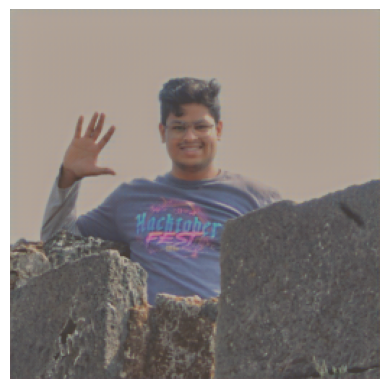

In [25]:
generator.eval()

# Perform inference
content_path = "tests/test-1.jpg"  # Replace with your content image path
text_prompt = "A still life of objects broken into geometric planes with muted earthy tones."     # Replace with your text prompt
styled_image = stylize(generator, content_path, text_prompt, device)

# Display the styled image
plt.imshow(styled_image)
plt.axis("off")
plt.show()

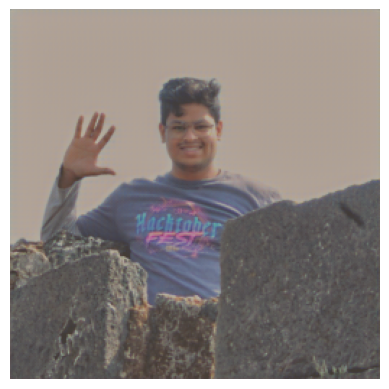

In [26]:
generator.eval()

# Perform inference
content_path = "tests/test-1.jpg"  # Replace with your content image path
text_prompt ="A mosaic-like scene created by juxtaposing fragmented pieces into an abstract whole."     # Replace with your text prompt
styled_image = stylize(generator, content_path, text_prompt, device)

# Display the styled image
plt.imshow(styled_image)
plt.axis("off")
plt.show()

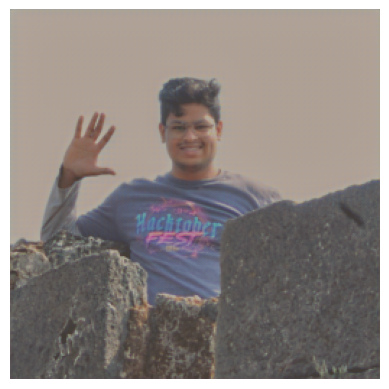

In [27]:
generator.eval()

# Perform inference
content_path = "tests/test-1.jpg"  # Replace with your content image path
text_prompt ="An abstract composition with a focus on simplification and geometric distortion."     # Replace with your text prompt
styled_image = stylize(generator, content_path, text_prompt, device)

# Display the styled image
plt.imshow(styled_image)
plt.axis("off")
plt.show()

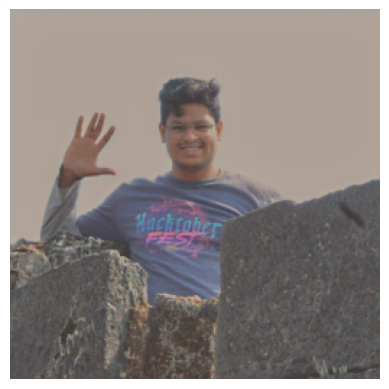

In [30]:

generator.eval()

# Perform inference
content_path = "tests/test-1.jpg"  # Replace with your content image path
text_prompt ="An urban scene reimagined through fragmented perspectives and interlocking shapes."     # Replace with your text prompt
styled_image = stylize(generator, content_path, text_prompt, device)

# Display the styled image
plt.imshow(styled_image)
plt.axis("off")
plt.show()